Loaded T2_2000-03.nc with Dask chunks
Loaded RAINNC_2000-03.nc with Dask chunks
Loaded SNOWNC_2000-03.nc with Dask chunks
Loaded HAILNC_2000-03.nc with Dask chunks
Loaded GRAUPELNC_2000-03.nc with Dask chunks
Loaded I_RAINNC_2000-03.nc with Dask chunks
Loaded T2_2000-03.nc with Dask chunks
Loaded I_RAINNC_2000-03.nc with Dask chunks
Loaded RAINNC_2000-03.nc with Dask chunks


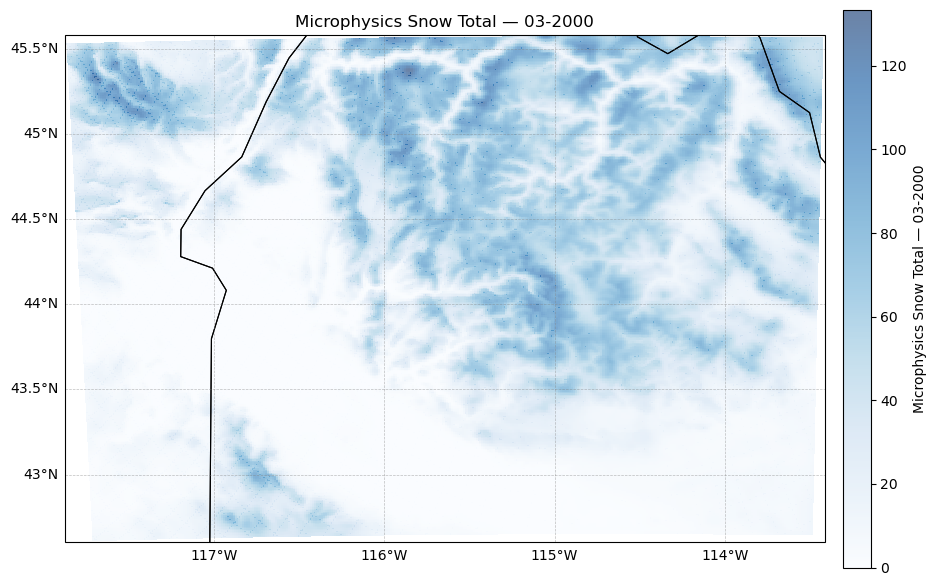

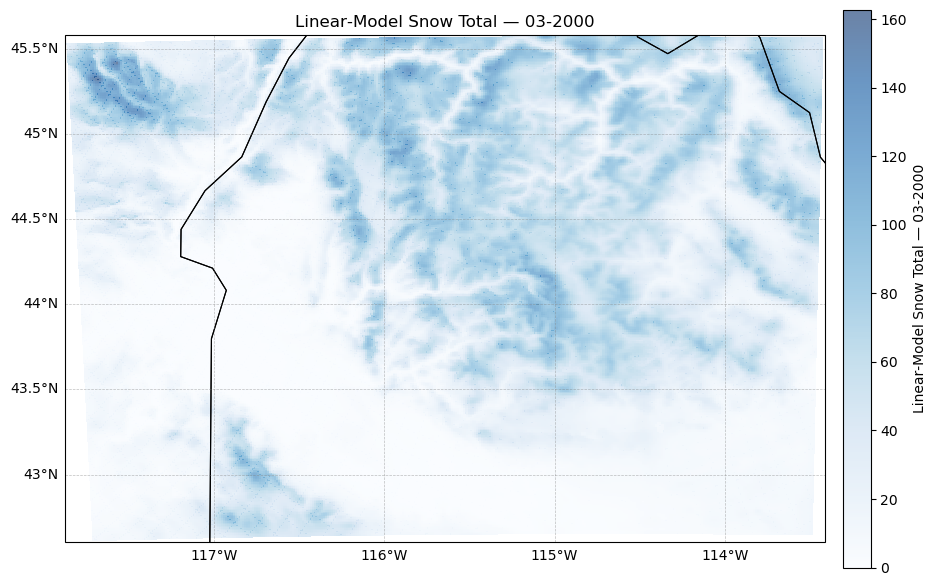

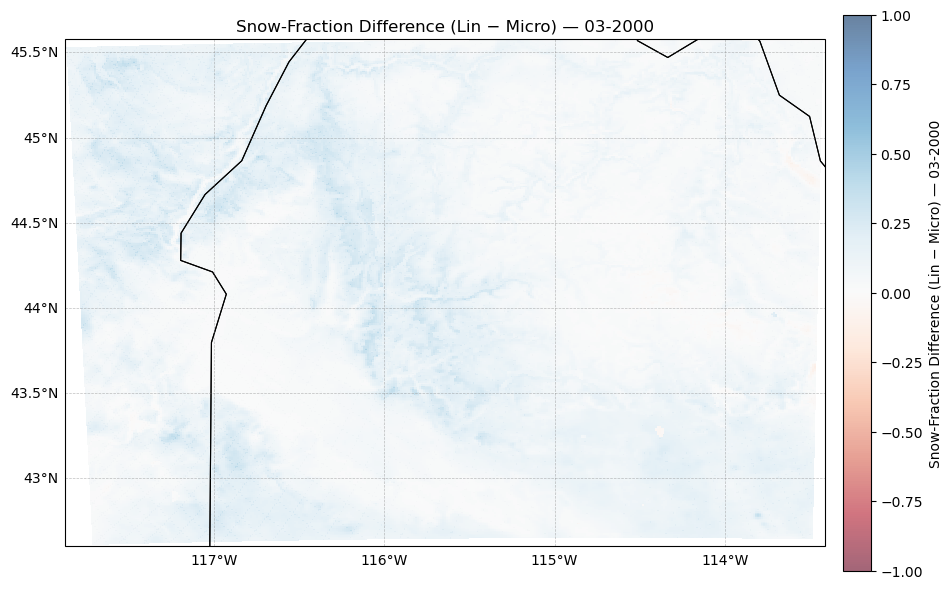

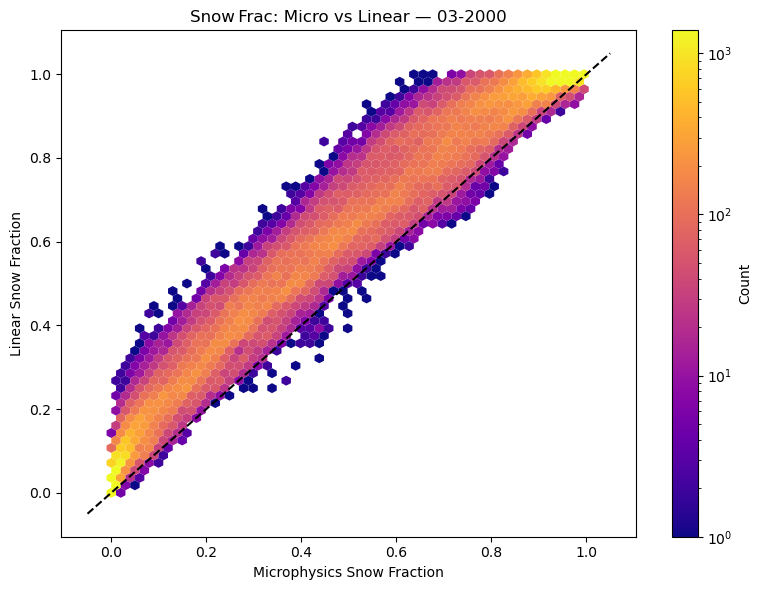

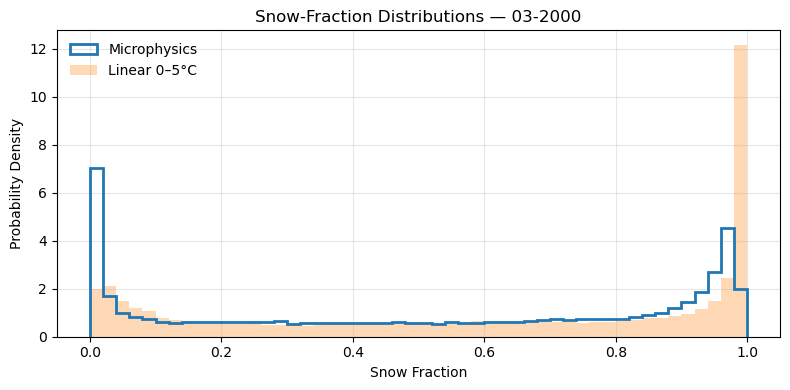

In [2]:
# -----------------------------------------------------------------------------
#   compare-03-2000.ipynb  —  DRIVER FOR PLOTS  
# -----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import plot_utils; reload(plot_utils)

from plot_utils import (
    load_wrf_var,
    compute_microphysics_snow_frac,
    compute_linear_snow_frac,
    plot_cartopy,
    plot_hexbin
)

# === CONFIGURATION ===
d02_dir = "/bsushare/leaf-shared/subset-output-wrf/vol04/wrf_out/wy_2000/d02/"
month, year = "03", "2000"
target_location = "Domain"

# === LOAD GRID FROM T2 FILE ===
t2_ds = load_wrf_var("T2", d02_dir, year, month)
lons = t2_ds["XLONG"][0].values
lats = t2_ds["XLAT"][0].values

# === COMPUTE MONTHLY FIELDS WITH MASKING ===
precip_micro, snow_micro, liquid_micro, frac_micro = compute_microphysics_snow_frac(
    d02_dir, year, month,
    min_precip=1.0, # mask threshold
    epsilon=1e-6
)

precip_lin, snow_lin, liquid_lin, frac_lin = compute_linear_snow_frac(
    d02_dir, year, month,
    min_precip_hr=0.1, # hourly mask threshold
    TSNOW_THRESHOLD=0.0,
    TRAIN_THRESHOLD=5.0,
    epsilon=1e-6
)

# === SPATIAL MAPS SIDE‐BY‐SIDE ===
plot_cartopy(lons, lats, snow_micro.values,  f"Microphysics Snow Total — {month}-{year}", cmap="Blues")
plot_cartopy(lons, lats, snow_lin.values,    f"Linear‐Model Snow Total — {month}-{year}", cmap="Blues")

# === DIFFERENCE MAP ===
diff_frac = frac_lin - frac_micro
plot_cartopy(lons, lats, diff_frac.values,
    f"Snow‑Fraction Difference (Lin − Micro) — {month}-{year}",
    cmap="RdBu", vmin=-1, vmax=1)

# === HEXBIN SCATTER OF SNOW FRACTION ===
fm = np.ma.masked_invalid(frac_micro.values)
fl = np.ma.masked_invalid(frac_lin.values)
fig, ax, hb = plot_hexbin(
    fm.compressed(),
    fl.compressed(),
    gridsize=50,
    cmap="plasma",
    xlabel="Microphysics Snow Fraction",
    ylabel="Linear Snow Fraction",
    title=f"Snow Frac: Micro vs Linear — {month}-{year}",
    overlay_one_one=True,
    log_counts=True,        # <- log color scale
    trim_zeros_ones=True,   # <- drop exact 0/1 bins
    trim_pct=99.0           # <- (optional) cap top 1% of bins
)

# === HISTOGRAMS ===
bins = np.linspace(0,1,51)
plt.figure(figsize=(8,4))
plt.hist(fm.compressed(), bins=bins, density=True,
         histtype="step", linewidth=2, label="Microphysics")
plt.hist(fl.compressed(), bins=bins, density=True,
         histtype="stepfilled", alpha=0.3, label="Linear 0–5°C")
plt.xlabel("Snow Fraction")
plt.ylabel("Probability Density")
plt.title(f"Snow‑Fraction Distributions — {month}-{year}")
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



